In [132]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns


def write_to_file(file_name, content):
    with open(file_name, 'w') as f:
        f.write(content)


# Dark theme
plt.style.use('dark_background')

# set grid thickness
plt.rcParams['grid.linewidth'] = 0.3

DEBUG = False

# Nacteni dat

In [133]:
def print_debug(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)

In [134]:
def load_data():
    DEBUG = True
    excel_file = pd.ExcelFile("Projekt-2_Data.xlsx")
    print_debug(excel_file.sheet_names)

    df_uloha_1: pd.DataFrame = excel_file.parse(excel_file.sheet_names[0])
    df_uloha_2 = excel_file.parse(excel_file.sheet_names[1])
    print_debug(df_uloha_1.head())
    print_debug(df_uloha_2.head())
    return {
        '1': df_uloha_1,
        '1_a': df_uloha_1['uloha_1 a)'],
        '1_b_prior': df_uloha_1['uloha_1 b)_prior'],
        '1_g': df_uloha_1['skupina'],
        '1_b_observation': df_uloha_1['uloha_1 b)_pozorování'],
        '2': df_uloha_2,
        '2_os': df_uloha_2['OSType'],
        '2_as': df_uloha_2['ActiveUsers'],
        '2_ip': df_uloha_2['InteractingPct'],
        '2_sp': df_uloha_2['ScrollingPct'],
        '2_p': df_uloha_2['Ping [ms]'],
    }


data = load_data()

In [135]:
# data

# ULOHA 1 - Bayesovske odhady

## ULOHA 1.a - Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení [2 body]

### Cleaning data
- Remove outliers

In [136]:
def task_1_b_data():
    connections = 10
    time = 5
    info_df1 = data
    return {
        'connections': connections,
        'time': time,
        'info_df1': info_df1
    }

In [137]:
def task_1_b_cleared_data(df_uloha_1: pd.DataFrame):
    # Extract observed data
    observed_data = df_uloha_1.values
    print_debug(f"{observed_data=}")
    print_debug(f"{len(observed_data)=}")

    # remove nan or +-inf values
    observed_data = observed_data[~np.isnan(observed_data)]
    print_debug(f"{observed_data=}")
    print_debug(f"{len(observed_data)=}")

    # Calculate Z-scores
    z_scores = stats.zscore(observed_data, nan_policy='raise')
    print_debug(f"{z_scores=}")
    print_debug(f"{len(observed_data)=}")

    # Define a threshold for outliers (e.g., 3 standard deviations)
    threshold = 3

    # Filter out rows with Z-scores beyond the threshold
    filtered_data = observed_data[(np.abs(z_scores) < threshold)]
    print_debug(f"{filtered_data=}")
    print_debug(f"{len(observed_data)=}")

    # Display the number of removed outliers
    print_debug(f"Number of removed outliers: {len(df_uloha_1.values) - len(filtered_data)}")
    return filtered_data


filtered_data = task_1_b_cleared_data(data['1_a'])
filtered_data

array([2., 2., 1., 3., 0., 1., 1., 3., 2., 2., 3., 1., 5., 3., 1., 1., 2.,
       1., 1., 1., 2., 3., 2., 0., 3., 1., 2., 1., 5., 1., 0., 0., 2., 1.,
       1., 0., 0., 1., 3., 1., 0., 1., 2., 0., 1., 3., 0., 1., 1., 4., 1.,
       2., 1., 1., 2., 4., 2., 2., 3., 4., 4., 4., 0., 2., 0., 0., 3., 5.,
       1., 2., 1., 0., 1., 1., 4., 1., 1., 3., 0., 1., 2., 2., 2., 3., 1.,
       2., 2., 2., 1., 2., 2., 1., 0., 1., 1., 3., 0., 3., 1., 1.])

## ULOHA 1.a.1 - Do jednoho obrázku vykreslíte apriorní a aposteriorní hustotou parametru Poissonova rozdělení $\lambda$.

In [138]:
def task_1_a_1_data():
    # Expertní odhad parametru λ
    lambda_expert = 10 / 5  # 10 připojení za 5 ms
    alpha_prior = 10  # connection count
    # alpha_prior = 2
    beta_prior = 5  # time within the connection count (alpha_prior) was observed
    # beta_prior = 1
    return {
        'lambda_expert': lambda_expert,
        'alpha_prior': alpha_prior,
        'beta_prior': beta_prior
    }

In [139]:
def task_1_a_1_prior():
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']

    # lambda prior
    lambda_prior = alpha_prior / beta_prior
    print_debug(f"{lambda_prior=}")

    x = np.linspace(0, np.max(filtered_data), 1000)
    y = stats.gamma.pdf(x, alpha_prior, scale=1 / beta_prior)
    return {
        'x': x,
        'y': y,
        "alpha_prior": alpha_prior,
        "beta_prior": beta_prior
    }


In [140]:
def task_1_a_1_posterior():
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']

    # posterior
    alpha_posterior = alpha_prior + np.sum(filtered_data)
    beta_posterior = beta_prior + len(filtered_data)

    # lambda_posterior
    lambda_posterior = alpha_posterior / beta_posterior
    print_debug(f"{lambda_posterior=}")

    # Posterior
    x = np.linspace(0, np.max(filtered_data), 1000)
    y = stats.gamma.pdf(x, alpha_posterior, scale=1 / beta_posterior)
    return {
        'x': x,
        'y': y,
        "alpha_posterior": alpha_posterior,
        "beta_posterior": beta_posterior
    }

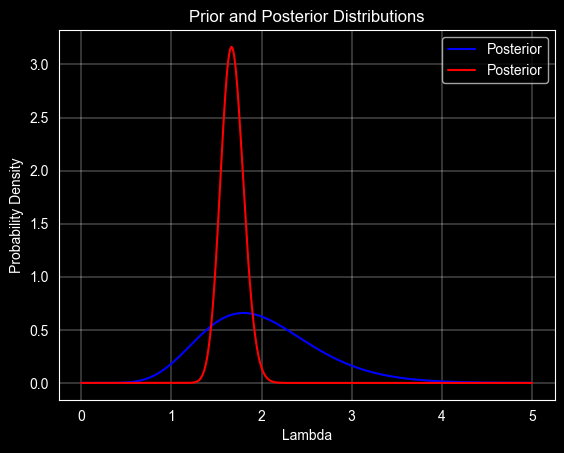

In [141]:
def task_1_a_1_plot():
    data_prior = task_1_a_1_prior()
    x = task_1_a_1_prior()['x']
    y = task_1_a_1_prior()['y']
    plt.plot(x, y, label='Posterior', color='blue')
    data_posterior = task_1_a_1_posterior()
    x = task_1_a_1_posterior()['x']
    y = task_1_a_1_posterior()['y']
    plt.plot(x, y, label='Posterior', color='red')
    plt.title('Prior and Posterior Distributions')
    plt.xlabel('Lambda')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()


task_1_a_1_plot()

## ULOHA 1.a.2 - Do jednoho obrázku vykreslíte apriorní a aposteriorní prediktivní hustotou pozorovaní $x$ za jeden časový interval.

In [142]:
def task_1_a_2_prior():
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']
    lambda_prior = data['lambda_expert']

    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)

    lambda_posterior = alpha_posterior / beta_posterior
    print(f"{lambda_posterior=}")

    x = range(0, 6)
    y = stats.nbinom.pmf(x, alpha_prior, beta_prior / (1 + beta_prior))
    return x, y

In [143]:
def task_1_a_2_posterior():
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']
    lambda_prior = data['lambda_expert']

    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)

    x = range(0, 6)
    y = stats.nbinom.pmf(x, alpha_posterior, beta_posterior / (1 + beta_posterior))
    return x, y

lambda_posterior=1.6761904761904762


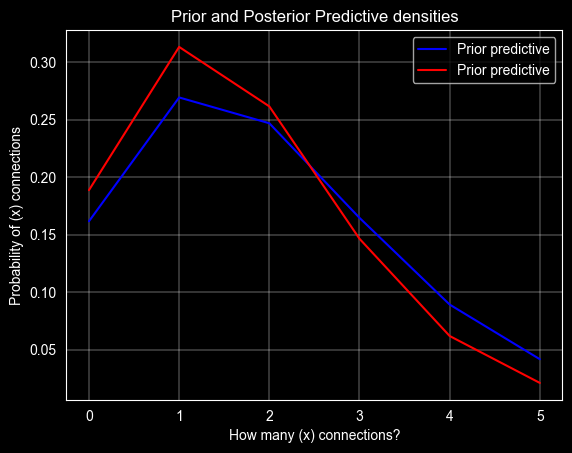

In [144]:
def task_1_a_2_plot():
    x, y = task_1_a_2_prior()
    plt.plot(x, y, label='Prior predictive', color='blue')
    x, y = task_1_a_2_posterior()
    plt.plot(x, y, label='Prior predictive', color='red')
    plt.title('Prior and Posterior Predictive densities')
    plt.xlabel('How many (x) connections?')
    plt.ylabel('Probability of (x) connections')
    plt.legend()
    plt.show()


task_1_a_2_plot()

In [145]:
def task_1_a_3():
    global DEBUG
    DEBUG = True
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']

    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)

    # Task 3: Construct 95% confidence intervals for λ from prior and posterior distributions
    prior_ci = stats.gamma.interval(0.95, alpha_prior, scale=1 / beta_prior)
    posterior_ci = stats.gamma.interval(0.95, alpha_posterior, scale=1 / beta_posterior)

    print_debug(f"Prior 95% CI for λ: {prior_ci[0]:.5f}, {prior_ci[1]:.5f}")
    print_debug(f"Posterior 95% CI for λ: {posterior_ci[0]:.5f}, {posterior_ci[1]:.5f}")


task_1_a_3()

Prior 95% CI for λ: 0.95908, 3.41696
Posterior 95% CI for λ: 1.43769, 1.93272


In [146]:
def task_1_a_4():
    global DEBUG
    DEBUG = True
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']

    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)

    # Task 4: Select two posterior point estimates for λ and compare them
    posterior_mean = alpha_posterior / beta_posterior
    posterior_mode = (alpha_posterior - 1) / beta_posterior

    print(f"Aposteriori mean: {posterior_mean:.5f}")
    print(f"Aposteriori mode: {posterior_mode:.5f}")


task_1_a_4()

Aposteriori mean: 1.67619
Aposteriori mode: 1.66667


In [147]:
def task_1_a_5():
    global DEBUG
    DEBUG = True
    data = task_1_a_1_data()
    alpha_prior = data['alpha_prior']
    beta_prior = data['beta_prior']

    alpha_posterior = alpha_prior + np.sum(filtered_data)  # Assuming filtered_data is defined
    beta_posterior = beta_prior + len(filtered_data)

    # Task 5: Select one prior and one posterior point estimate for the number of observations
    mu_prior = alpha_prior / beta_prior
    mu_posterior = alpha_posterior / beta_posterior

    print(f"Prior estimate: {mu_prior:.5f}")
    print(f"Posterior estimate: {mu_posterior:.5f}")


task_1_a_5()

Prior estimate: 2.00000
Posterior estimate: 1.67619


## ULOHA 1.b - Aproximace diskrétním rozdělením [2 body]

### Load data

In [148]:
def task_1_b_cleared_data(prior_data,
                          observed_data,
                          group_column):
    global DEBUG
    DEBUG = 0

    #Filter inf and nan values
    prior_data = prior_data[~np.isnan(prior_data)]
    observed_data = observed_data[~np.isnan(observed_data)]
    group_column = group_column[~np.isnan(group_column)]
    print_debug(f"{prior_data=}")
    print_debug(f"{len(prior_data)=}")
    print_debug()
    print_debug(f"{observed_data=}")
    print_debug(f"{len(observed_data)=}")
    print_debug()
    print_debug(f"{group_column=}")
    print_debug(f"{len(group_column)=}")
    print_debug()
    return {
        'prior_data': prior_data,
        'observed_data': observed_data,
        'group_column': group_column
    }

# task_1_b_cleared_data(data['1_b_prior'], data['1_b_observation'], data['1_g'])

### Uloha 1.b.1: Plot prior, posterior, and likelihood functions

In [149]:
def task_1_b_1_data():
    global DEBUG
    # parameters for prior distribution
    mu = 3
    sigma_squared = 1
    a = 1
    return {
        'mu': mu,
        'sigma_squared': sigma_squared,
        'a': a
    }

In [150]:
# max_per_group = data['1'].groupby('skupina')['uloha_1 b)_prior'].max().reset_index()
max_per_group = data['1'].groupby('skupina')['uloha_1 b)_prior'].max()
# max_per_group = data['1']
max_per_group

skupina
0       5.021816
1       4.392436
2       5.827102
3       4.531723
4       5.461728
          ...   
9995    5.001767
9996    5.771658
9997    5.579720
9998    5.063841
9999    4.487418
Name: uloha_1 b)_prior, Length: 10000, dtype: float64

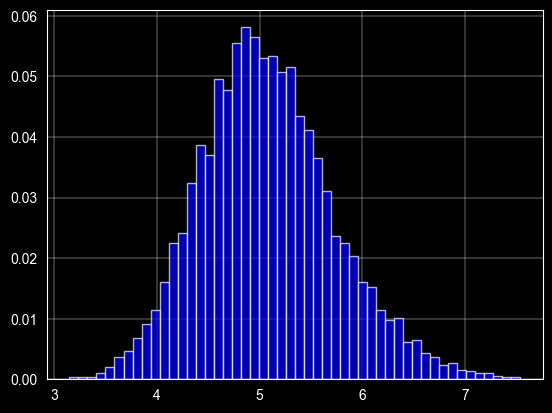

In [151]:
aprior_data_max = data['1'].groupby('skupina')['uloha_1 b)_prior'].max().reset_index()

# Získanie všetkých najväčších hodnôt do jednej dátovej sady
all_max_values = aprior_data_max['uloha_1 b)_prior']

# Určenie hraníc binov pre rovnomerné rozdelenie
all_max_values.max()
bin_width = (all_max_values.max() - all_max_values.min()) / 50
bins = np.arange(all_max_values.min(), all_max_values.max(), bin_width)

bin_height, bin_edges = np.histogram(all_max_values, bins=50)
bin_height = bin_height / np.sum(bin_height)

# Vytvorenie histogramu pre diskrétne rozdelenie
# plt.hist(all_max_values, bins=bins, edgecolor='black', alpha=0.7,density=True)
plt.bar(x=bins, height=bin_height, width=bin_width, color='blue', alpha=0.7)
plt.show()



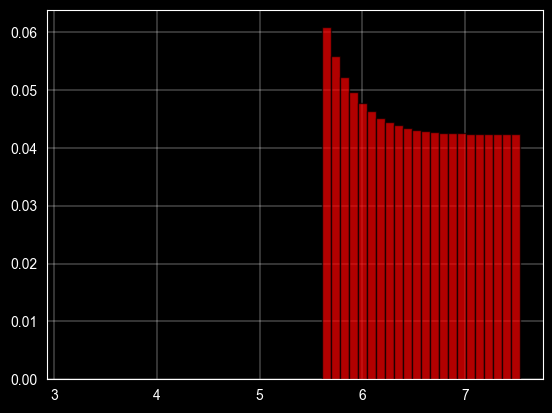

In [152]:
# Likelihood function
mu = 3
sigma = np.sqrt(1)
a = 1

observed_data = task_1_b_cleared_data(data['1_b_prior'], data['1_b_observation'], data['1_g'])['observed_data']
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


def likelyhood_func(observed_data, b):
    a_truncnorm = (a - mu) / sigma
    b_truncnorm = (b - mu) / sigma
    pdf = stats.truncnorm.pdf(observed_data, a=a_truncnorm, b=b_truncnorm, loc=mu, scale=sigma)
    return pdf


likelihood = [likelyhood_func(observed_data, b_center) for b_center in bin_centers]
likelihood = np.prod(likelihood, axis=1)
# likelihood

likelihood_normalized = likelihood / np.sum(likelihood)
plt.bar(x=bins, height=likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Likelyhood',
        alpha=0.7)
plt.show()

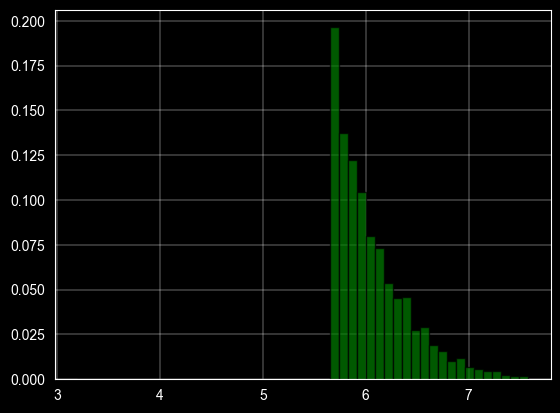

In [153]:
# Aposteriórna pst
posterior_probs = likelihood * bin_height
posterior_probs_normalized = posterior_probs / np.sum(posterior_probs)
plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green',
        label='Aposteriórne rozdelenie', alpha=0.7)
plt.show()

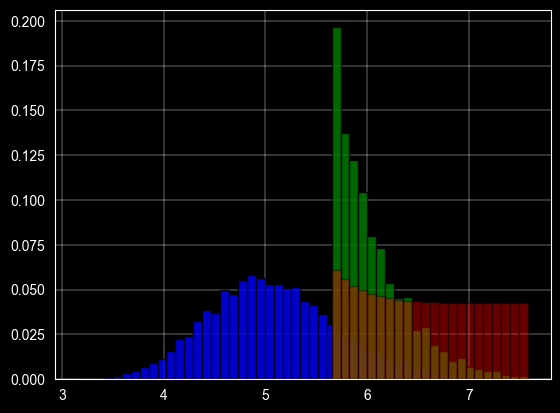

In [154]:
# Plot apriorné rozdelenie
plt.bar(x=bins, height=bin_height, width=bin_width, color='blue', alpha=0.8, edgecolor='black')
plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green',
        label='Aposteriórne rozdelenie', alpha=0.8)
plt.bar(bin_centers, likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Vierohodnosť',
        alpha=0.4)
plt.show()

### Uloha 1.b.2. Z aposteriorní hustoty určete 95% interval spolehlivosti (konfidenční interval) pro parametr 𝑏.

In [209]:
# posterior_probs_normalized
# cumulative_posterior[45:]
# bin_centers
# cumulative_posterior
# np.argmax(cumulative_posterior)
# np.argmin(cumulative_posterior)
# np.argmax(cumulative_posterior>=0.025)
# np.argmin(cumulative_posterior<=0.975)
# (cumulative_posterior>=0.025)[10:30]
# cumulative_posterior<=0.975

28

In [211]:
# Určení 95% intervalu spolehlivosti
cumulative_posterior = np.cumsum(posterior_probs_normalized)
lower_bound = bin_centers[np.argmax(cumulative_posterior >= 0.025)]
upper_bound = bin_centers[np.argmin(cumulative_posterior <= 0.975)]
print(f'95% Confidence Interval for Parameter b: {lower_bound:.5f}, {upper_bound:.5f}')

95% Confidence Interval for Parameter b: 5.69371, 7.00891


### Uloha 1.b.3. Vyberte dva bodové odhady parametru 𝑏 a spočítejte je.

In [205]:
# Vybrání dvou bodových odhadů
mean = np.sum(bin_centers * posterior_probs_normalized)
median = bin_centers[np.argmax(posterior_probs_normalized)]
print(f'First point estimate: {mean:.5f}')
print(f'Second point estimate: {median:.5f}')  # Is this value OK?

First point estimate: 6.05277
Second point estimate: 5.69371


# ULOHA 2 - ÚLOHA 2 – Regrese – 8. bodů

## ULOHA 2.1. [4. body] Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí „plný“ model považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které dávají smysl).

### ULOHA 2.1.1 Zapište rovnici Vašeho finálního modelu.

### ULOHA 2.1.2 Diskutujte splnění předpokladů lineární regrese a základní regresní diagnostiky.

### ULOHA 2.1.3 Pokud (až během regresního modelování) identifikujete některé „extrémně odlehlé hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém zdůvodnění, vyřadit.

    OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0      iOS         4113          0.8283        0.1717         47
1      iOS         7549          0.3461        0.6539         46
2  Windows         8855          0.2178        0.7822         55
3  Android         8870          0.0794        0.9206         56
4    MacOS         9559          0.7282        0.2718         76
       ActiveUsers  InteractingPct  ScrollingPct   Ping [ms]
count   502.000000      502.000000    502.000000  502.000000
mean   5485.830677        0.488613      0.511387   50.545817
std    2548.935679        0.296000      0.296000   14.797937
min     153.000000        0.000500      0.001400   11.000000
25%    3357.500000        0.229300      0.257525   40.000000
50%    5456.000000        0.482950      0.517050   52.000000
75%    7461.500000        0.742475      0.770700   60.000000
max    9953.000000        0.998600      0.999500   90.000000


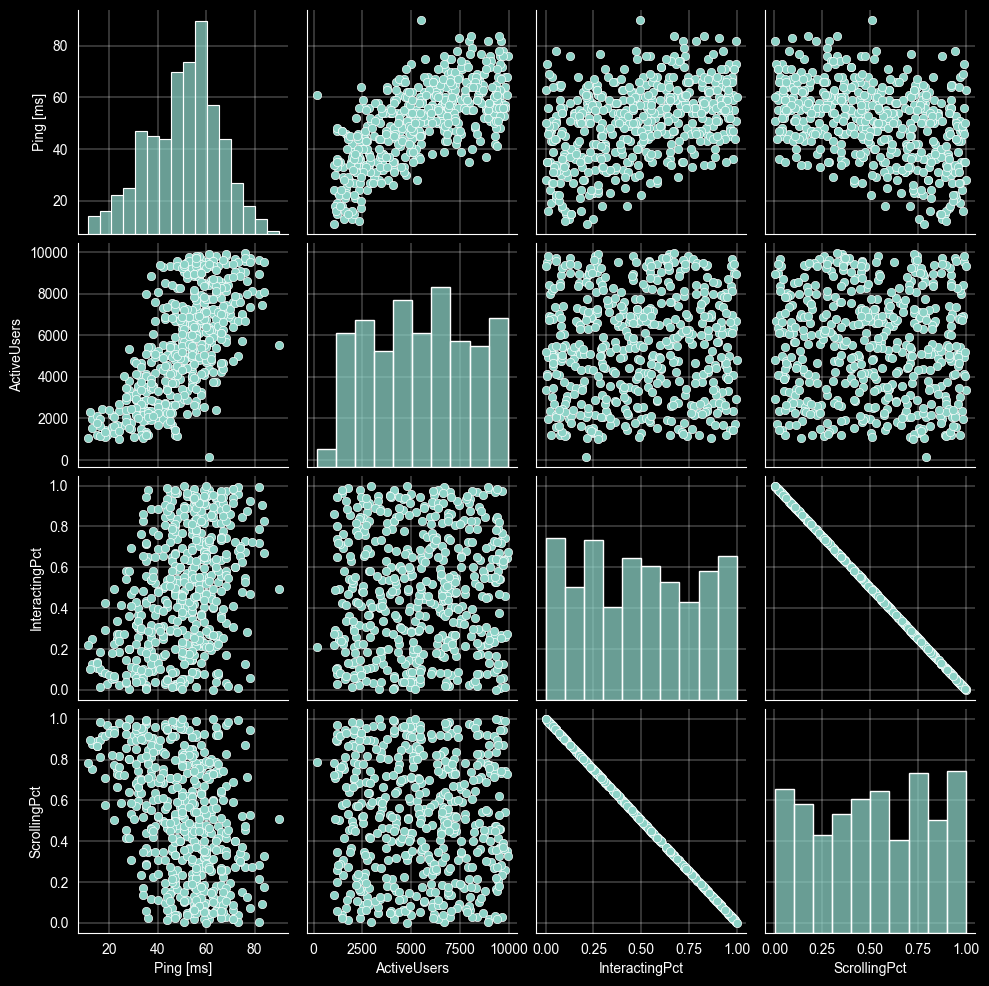

In [26]:
# Načtení dat
df_uloha_2 = data['2']

# Předběžná analýza dat
print(df_uloha_2.head())
print(df_uloha_2.describe())

# Vizualizace dat
sns.pairplot(df_uloha_2[['Ping [ms]', 'ActiveUsers', 'InteractingPct', 'ScrollingPct']])
plt.show()

In [228]:
X = pd.DataFrame()
X['ActiveUsers'] = df_uloha_2.loc[:, 'ActiveUsers']
X['InteractingPct'] = df_uloha_2.loc[:, 'InteractingPct']
X['ScrollingPct'] = df_uloha_2.loc[:, 'ScrollingPct']
correlation_matrix = np.corrcoef(X.values.T)
X.values.T
# X.values
correlation_matrix

array([[ 1.       ,  0.0402748, -0.0402748],
       [ 0.0402748,  1.       , -1.       ],
       [-0.0402748, -1.       ,  1.       ]])

In [343]:
X = pd.DataFrame()

# Base keys
X['ActiveUsers'] = df_uloha_2.loc[:, 'ActiveUsers']
# X['ActiveUsers'] = (df_uloha_2.loc[:, 'ActiveUsers'] - df_uloha_2.loc[:, 'ActiveUsers'].mean()) / df_uloha_2.loc[:, 'ActiveUsers'].std()
X['InteractingPct'] = df_uloha_2.loc[:, 'InteractingPct']
# X['InteractingPct'] = (df_uloha_2.loc[:, 'InteractingPct'] - df_uloha_2.loc[:, 'InteractingPct'].mean()) / df_uloha_2.loc[:, 'InteractingPct'].std()
# X['OSType'] = df_uloha_2.loc[:,'OSType']
X['InteractingPct^2'] = X['InteractingPct'] ** 2

# OS types Instead True/False values, we can use 1/0
X['Windows'] = df_uloha_2['OSType'].apply(lambda x: 1 if x == 'Windows' else 0)
X['iOS'] = df_uloha_2['OSType'].apply(lambda x: 1 if x == 'iOS' else 0)
X['MacOS'] = df_uloha_2['OSType'].apply(lambda x: 1 if x == 'MacOS' else 0)
X['Android'] = df_uloha_2['OSType'].apply(lambda x: 1 if x == 'Android' else 0)

X['ActiveUsers^2'] = X['ActiveUsers'] ** 2
X['ActiveUsers*InteractingPct'] = X['ActiveUsers'] * X['InteractingPct']
X['ActiveUsers*OSType_windows'] = X['ActiveUsers'] * X['Windows']
X['ActiveUsers*OSType_iOS'] = X['ActiveUsers'] * X['iOS']
X['ActiveUsers*OSType_MacOS'] = X['ActiveUsers'] * X['MacOS']
X['ActiveUsers*OSType_Android'] = X['ActiveUsers'] * X['Android']

X['InteractingPct^2'] = X['InteractingPct'] ** 2
X['InteractingPct*OSType_windows'] = X['InteractingPct'] * X['Windows']
X['InteractingPct*OSType_iOS'] = X['InteractingPct'] * X['iOS']
X['InteractingPct*OSType_MacOS'] = X['InteractingPct'] * X['MacOS']
X['InteractingPct*OSType_Android'] = X['InteractingPct'] * X['Android']

# Const
X = sm.add_constant(X)  # přidání konstanty 1.0

X.tail()
y = df_uloha_2['Ping [ms]']
model = sm.OLS(endog=y, exog=X).fit()
print(model.summary())
write_to_file('model_summary.txt', model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        17:50:47   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [344]:
# Remove from X the values taht has p-value >= 0.05
b = model.pvalues > 0.05
b = b[b == True].index
b = b.drop('const') if 'const' in b else b

# Check if X has columns defined in b
drop_columns = [i for i in b if i in X.columns]
X = X.drop(drop_columns, axis=1)

# Retrain model
model = sm.OLS(endog=y, exog=X).fit()
print(model.summary())
write_to_file('model_summary.txt', model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     239.3
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          4.65e-189
Time:                        17:50:47   Log-Likelihood:                -1599.6
No. Observations:                 502   AIC:                             3223.
Df Residuals:                     490   BIC:                             3274.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [345]:
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
vif

/Users/zlapik/repos/msp-project2/venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


const                            36.482518
ActiveUsers                            inf
InteractingPct                         inf
Windows                           7.956856
ActiveUsers^2                    22.279607
ActiveUsers*InteractingPct        8.700978
ActiveUsers*OSType_windows             inf
ActiveUsers*OSType_iOS                 inf
ActiveUsers*OSType_MacOS               inf
ActiveUsers*OSType_Android             inf
InteractingPct*OSType_windows          inf
InteractingPct*OSType_iOS              inf
InteractingPct*OSType_MacOS            inf
InteractingPct*OSType_Android          inf
dtype: float64

In [ ]:
influence = model.get_influence()
influence.resid_studetized_internal
# Leverage 
# leverage = influence.hat_matrix_diag



In [ ]:
# Předpoklady lineární regrese a regresní diagnostika
# Graf reziduí
x = model.fittedvalues
# x
plt.scatter(x, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

In [ ]:
# Testy a diagnostika
residuals = model.resid
# residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

In [ ]:
# Heteroskedasticita
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted (Heteroskedasticity Check)')
plt.show()

## ULOHA 2.2. [1. body] - Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva nejproblematičtější hodnotu.

## ULOHA 2.3. [1. bod] - Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.

## ULOHA 2.4. [2. body] - Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model „vhodný“ pro další použití.

In [ ]:
# Načtení dat
data = data['2']

# Přidání kvadratických termínů
data['ActiveUsers_squared'] = data['ActiveUsers'] ** 2
data['InteractingPct_squared'] = data['InteractingPct'] ** 2
data['ScrollingPct_squared'] = data['ScrollingPct'] ** 2

# Přidání interakcí druhého řádu
data['ActiveUsers_InteractingPct'] = data['ActiveUsers'] * data['InteractingPct']
data['ActiveUsers_ScrollingPct'] = data['ActiveUsers'] * data['ScrollingPct']
data['InteractingPct_ScrollingPct'] = data['InteractingPct'] * data['ScrollingPct']

# Plný kvadratický model
model_formula = 'ping ~ ActiveUsers + InteractingPct + ScrollingPct + ActiveUsers_squared + InteractingPct_squared + ScrollingPct_squared + ActiveUsers_InteractingPct + ActiveUsers_ScrollingPct + InteractingPct_ScrollingPct + OSType'

# Fit regresního modelu
model = sm.OLS.from_formula(model_formula, data=data)
results = model.fit()

# Výpis výsledků
print(results.summary())

# Regresní diagnostika
sns.residplot(x=results.fittedvalues, y=results.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

# Test normality reziduí
sm.qqplot(results.resid, line='s')
plt.title('Normal Q-Q plot')
plt.show()

# VIF pro detekci multicollinearity
X = data[['ActiveUsers', 'InteractingPct', 'ScrollingPct', 'ActiveUsers_squared', 'InteractingPct_squared',
          'ScrollingPct_squared', 'ActiveUsers_InteractingPct', 'ActiveUsers_ScrollingPct',
          'InteractingPct_ScrollingPct']]
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# Identifikace odlehlých hodnot
influence = results.get_influence()
leverage = influence.hat_matrix_diag
residuals_studentized = influence.resid_studentized_internal
outliers = np.where((np.abs(residuals_studentized) > 2) | (leverage > 0.02))

# Vyhodnocení výsledků a rozhodnutí o odstranění odlehlých hodnot (pokud je to nutné)

# Analýza parametrů
param_analysis = results.params

# Identifikace nejproblematičtější hodnoty
max_residual = data.loc[outliers[0], 'ping'].max()

# Odhad odezvy uživatele s Windows
windows_user = pd.DataFrame({'ActiveUsers': [data['ActiveUsers'].mean()],
                             'InteractingPct': [data['InteractingPct'].mean()],
                             'ScrollingPct': [data['ScrollingPct'].mean()],
                             'ActiveUsers_squared': [data['ActiveUsers_squared'].mean()],
                             'InteractingPct_squared': [data['InteractingPct_squared'].mean()],
                             'ScrollingPct_squared': [data['ScrollingPct_squared'].mean()],
                             'ActiveUsers_InteractingPct': [data['ActiveUsers_InteractingPct'].mean()],
                             'ActiveUsers_ScrollingPct': [data['ActiveUsers_ScrollingPct'].mean()],
                             'InteractingPct_ScrollingPct': [data['InteractingPct_ScrollingPct'].mean()],
                             'OSType': ['Windows']})
predicted_ping = results.predict(windows_user)

# Konfidenční interval a predikční interval
conf_interval = results.get_prediction(windows_user).conf_int()
pred_interval = results.get_prediction(windows_user).conf_int(obs=True)

# Vyhodnocení modelu pro další použití
# Zde můžete diskutovat o tom, zda jsou výsledky modelu uspokojivé a zdali je model vhodný pro další použití.
